# This code implements segmentation of pathological regions from retinal images using a U-net model with depth 4 and tensorflow 2.x versions.

## This code implements multi-class classification
## This model is adapted from the original codebase in https://github.com/HZCTony/U-net-with-multiple-classification

In [2]:
# First lets connect the Gdrive that contains the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/U-net Multi-class/code/')
!ls

 model_depth_4.py
 __pycache__
'Step 1: One-Hot-encoded_GT_creation_3_classes.ipynb'
'Step 2: Monitoring_TF2_Unet_model.ipynb'
 U-net_binary_DB1.ipynb
 wandb


In [4]:
%%capture
!pip install wandb

In [5]:
import wandb
from wandb.keras import WandbCallback

In [6]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# A. Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [7]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [8]:
#Step 2: Import the U-net model
from model_depth_4 import *
img_size=(512,512)

In [9]:
n_class=3
#Create Groundtruth with 5 planes:[Red Lesions(0), Bright Lesions(1), background (2) ]

In [10]:
#Step 3:Define functions for pre-processing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc


def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "rgb",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = True,n_class = n_class,save_to_dir = None,target_size = img_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        yield (img,mask)
    

def testGenerator(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    print(num_image)
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = True)
        img = trans.resize(img,target_size)
        img = np.reshape(img,(1,)+img.shape)
        yield (img)

In [11]:
def Data_drift_monitor(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    print(num_image)
    max_val=[]
    mean_val=[]
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = True)
        max_val.append(np.max(img))
        mean_val.append(np.mean(img))
       
    return (np.array(mean_val),np.array(max_val))

In [12]:
def SaveResultwImage(img_path,save_path,npyfile,target_size=img_size,flag_multi_class = True,num_class = 2):
    files=os.listdir(img_path)
    
    
    for i,item in enumerate(npyfile):
        img=item
        img[img>0.5]=1
        img[img<=0.5]=0
        img[:,:,2]=0
        
        I = io.imread(os.path.join(img_path,files[i]), as_gray=True)
        I = trans.resize(I,target_size)
        img[:,:,0]=np.true_divide((I+img[:,:,0]),2)
        img[:,:,1]=np.true_divide((I+img[:,:,1]),2)
        img[:,:,2]=np.true_divide((I+img[:,:,2]),2)
        io.imsave(os.path.join(save_path, files[i]+'.jpg'),img)        

In [13]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)
    
    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""
   
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score

def evalResult(gth_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 3):
    files=sorted(os.listdir(gth_path))
    print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        gth1=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
        p,r,I,a,f=get_validation_metrics(gth1,img1)
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        f1_score=f1_score+f
    print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "IoU=",IoU/(i+1), "acc=",acc/(i+1), "F1=",f1_score/(i+1))    

# All definitions are now done! Lets start using the functions now...
# B. Call to image data generator, model initialization, followed by model fitting.

In [14]:
#Step 1: Call to image data generator in keras

os.chdir('/content/drive/MyDrive/U-net Multi-class/diaretdb1_v_1_1/resources/')
data_gen_args = dict(rotation_range=0.3,
                     rescale=1./255,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.1,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
PATH='./train/'

In [15]:
if not os.path.exists(PATH+'aug'):
    os.makedirs(PATH+'aug')
    
if not os.path.exists(PATH+'pred'):
    os.makedirs(PATH+'pred')    


In [16]:
data_gen = trainGenerator(1,PATH,'images','GT',data_gen_args, save_to_dir = None)

Epoch 0
Found 27 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
0.7477838


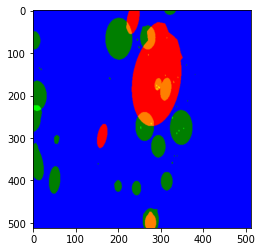

Epoch 1
0.85760754


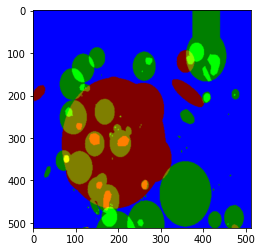

Epoch 2
0.7464642


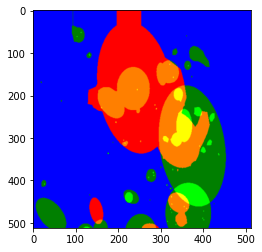

Epoch 3
0.47372508


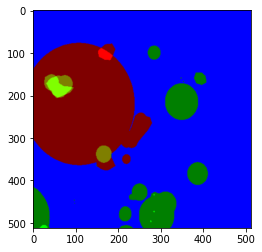

Epoch 4
0.52354825


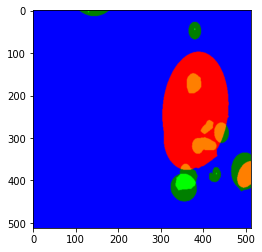

In [17]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in data_gen:
        print(np.max(x_batch))
        plt.imshow(np.squeeze(y_batch), cmap=plt.get_cmap('gray'))
        

        plt.show()
        
        break

In [18]:
#Step 2: Initialize the model. Train from scratch!
# Initialize wandb with your project name
run = wandb.init(project='Unet_process',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 30,
                     "batch_size": 3,
                     "loss_function": "binary_crossentropy",
                     "architecture": "CNN",
                     "dataset": "DIARETDB1"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = unet()
model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

wandb: Currently logged in as: sohinirc (use `wandb login --relogin` to force relogin)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
# Next we need to generate randomly transformed training data
x_train=[]
y_train=[]

for e in range(100):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in data_gen:
        x_train.append(np.squeeze(x_batch))
        y_train.append(np.squeeze(y_batch))
        
        break
x_train=np.array(np.expand_dims(x_train,3))
y_train=np.array(y_train)
print(np.shape(x_train))

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
(100, 512, 512, 1)


In [20]:
# Notice WandbCallback is used as a regular callback
# We again use config
_ = model.fit(x_train, y_train,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          callbacks=[WandbCallback()])

Epoch 1/30
34/34 [==============================] - 37s 372ms/step - loss: 0.5333 - acc: 0.6353
Epoch 2/30
34/34 [==============================] - 10s 281ms/step - loss: 0.4191 - acc: 0.6762
Epoch 3/30
34/34 [==============================] - 10s 282ms/step - loss: 0.3876 - acc: 0.7099
Epoch 4/30
34/34 [==============================] - 10s 281ms/step - loss: 0.4058 - acc: 0.6869
Epoch 5/30
34/34 [==============================] - 10s 280ms/step - loss: 0.3761 - acc: 0.7337
Epoch 6/30
34/34 [==============================] - 10s 281ms/step - loss: 0.3736 - acc: 0.7186
Epoch 7/30
34/34 [==============================] - 10s 281ms/step - loss: 0.3643 - acc: 0.7401
Epoch 8/30
34/34 [==============================] - 10s 281ms/step - loss: 0.3378 - acc: 0.7688
Epoch 9/30
34/34 [==============================] - 10s 281ms/step - loss: 0.3382 - acc: 0.7575
Epoch 10/30
34/34 [==============================] - 10s 281ms/step - loss: 0.3101 - acc: 0.7772
Epoch 11/30
34/34 [====================

# The ML training curves are now observable in Weights and Biases
# C. Monitor the test Data now on Weights and Biases!

In [21]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./test/images/'))
#Call test generator
test_gen= testGenerator('./test/images/')


In [22]:
#Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


62
62/62 [==============================] - 58s 944ms/step


In [23]:
# Monitor Data drift parameters
min_values,max_values=Data_drift_monitor('./test/images/')


62


In [24]:
# MOnitor image quality parameters for concept drift
test_gen_1 = testGenerator('./test/images/')
results_1 = model.predict_generator(test_gen_1,n_i,verbose=1)

62
 1/62 [..............................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


62/62 [==============================] - 9s 142ms/step


# Now we have monitored the ML model training, but next, we need to monitor test-time data performance, or pre-production testing!

In [25]:
#Test time wandb logging 

experiment_name = wandb.util.generate_id()

run=wandb.init(project='Unet_process',
           group=experiment_name,
           notes='This is Test Run')

import time

for epoch in range(n_i):
  #Next lets declare the metrics to monitor at production time
  start_time = time.time()
  print(epoch)
  #for images in test_gen: # Consider single image at a time
  pred=(results[epoch]>0.5).astype(int)
  pred_1=(results_1[epoch]>0.5).astype(int)
  RL=np.sum(pred[:,:,0])/(512*512)
  BL=np.sum(pred[:,:,1])/(512*512)
  IOU_RL=np.sum(pred[:,:,0]*pred_1[:,:,0])/np.sum((pred[:,:,0]+pred_1[:,:,0])>0)
  IOU_BL=np.sum(pred[:,:,1]*pred_1[:,:,1])/np.sum((pred[:,:,1]+pred_1[:,:,1])>0)
  data_min=min_values[epoch]
  data_max=max_values[epoch]
  batch_time=time.time() - start_time

  wandb.log({
           "Batch Time": batch_time,
           "RL Fractional Area": RL,
           "BL Fractional Area": BL,
           "IOU RL": IOU_RL,
           "IOU BL": IOU_BL,
           "Data Min": data_min,
           "Data_Max": data_max}) 
 


epoch,29
loss,0.19843
acc,0.87773
_runtime,428
_timestamp,1621034453
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
acc,▁▂▂▂▃▃▄▄▄▄▄▅▄▅▅▅▅▆▆▆▆▆▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


# Finally modify for a new data set (STARE) and see how model parameters change

In [26]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./test/STARE/'))
#Call test generator
test_gen = testGenerator('./test/STARE/')
results = model.predict_generator(test_gen,n_i,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


20
20/20 [==============================] - 14s 745ms/step


In [27]:
test_gen_1 = testGenerator('./test/STARE/')
results_1 = model.predict_generator(test_gen_1,n_i,verbose=1)

20
 2/20 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


20/20 [==============================] - 1s 50ms/step


In [28]:
# Monitor Data drift parameters
min_values,max_values=Data_drift_monitor('./test/STARE/')

20


In [29]:
#Test time wandb logging

experiment_name = wandb.util.generate_id()

run=wandb.init(project='Unet_process',
           group=experiment_name,
           notes='This is Test Run')

import time

for epoch in range(n_i):
  #Next lets declare the metrics to monitor at production time
  start_time = time.time()
  print(epoch)
  #for images in test_gen: # Consider single image at a time
  pred=(results[epoch]>0.5).astype(int)
  pred_1=(results_1[epoch]>0.5).astype(int)
  RL=np.sum(pred[:,:,0])/(512*512)
  BL=np.sum(pred[:,:,1])/(512*512)
  IOU_RL=np.sum(pred[:,:,0]*pred_1[:,:,0])/np.sum((pred[:,:,0]+pred_1[:,:,0])>0)
  IOU_BL=np.sum(pred[:,:,1]*pred_1[:,:,1])/np.sum((pred[:,:,1]+pred_1[:,:,1])>0)
  data_min=min_values[epoch]
  data_max=max_values[epoch]
  batch_time=time.time() - start_time

  wandb.log({
           "Batch Time": batch_time,
           "RL Fractional Area": RL,
           "BL Fractional Area": BL,
           "IOU RL": IOU_RL,
           "IOU BL": IOU_BL,
           "Data Min": data_min,
           "Data_Max": data_max}) 

Batch Time,0.01083
RL Fractional Area,0.00349
BL Fractional Area,0.00132
IOU RL,0.13068
IOU BL,0.09261
Data Min,0.09461
Data_Max,0.36246
_runtime,4
_timestamp,1621034622
_step,61


Batch Time,▅▂▁▂▁▁▁▁▁▁▁▁▁▃▄▃█▇▃▃▄▂▂▂▆▅▄▃▂▃▄▂▄▃▆▃▃▃▃▃
RL Fractional Area,▁▃▁▁▁▃▁▂▂▁▁▁▂▁▂▁█▁▁▂▁▁▁▁▂▄▁▁▁▁▁▁▁▁▁▁▃▄▁▁
BL Fractional Area,▄█▂▂▁▁▁▁▂▁▁▁▁▁▂▂▃▁▃▁▁▁▁▁▄▆▂▁▂▂▂▂▁▁▁▁▂▂▂▁
IOU RL,▃▆▁ ▃▇▂▇█ ▇▁▇▇█ ▇▂▃▆ ▅ ▁▇█ ▁▂ ▂▁ ▇█▁▂
IOU BL,▆▇▇▇▁█▆▆▆▆▅▅▆▅▅▇▄▅▆▅▆▆▅▃▇▇▆▆▇▆██▇▅▂▁▇▇▆▂
Data Min,▃▄▃▁▄▃▂▁▂▁▆▁▂▃▃▂▄▄▅▃▄▃▃▃▃▅▂▁▂▄▃▂▄▂▂▂▇█▂▁
Data_Max,▄▅▄▂▅▄▂▂▄▄▆▁▃▇█▁▇█▆▃▂▂▃▅▃▇▂▂▃▇█▄▇▄▃▄▅▇▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████████████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [30]:
#Lets save the STARE predictions
if not os.path.exists('./test/STARE_pred'):
    os.makedirs('./test/STARE_pred/')
print(PATH)
SaveResultwImage('./test/STARE/','./test/STARE_pred/',results)

./train/


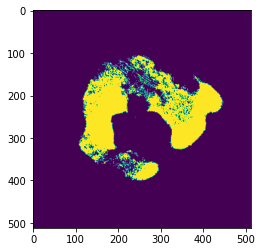

In [31]:
#Lets visualize the STARE predictions
plt.imshow(results[1][:,:,0]>0.5)

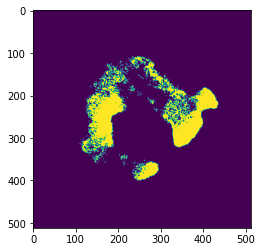

In [32]:
# Lets visualize agreeability between multiple test runs
plt.imshow((results_1[1][:,:,0]*results[1][:,:,0])>0.5)